# Is podium


## Dependencies


The dependencies used are as follows


In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer

import sys

sys.path.append("..")

from utils.visualization import model_tuning
from utils.custom_cvs import VariableTimeSeriesSplit
from utils.custom_scorers import balanced_accuracy_score

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Initialization


We continue with the tuning of the model that predicts the podium


In [2]:
df = pd.read_csv("../assets/data/processed/adding_data.csv")

mid_rc = df.groupby("raceYear")["raceRound"].max().to_numpy() // 2
get_half = lambda x: f'{x["raceYear"]}{x["raceRound"] <= mid_rc[x["raceYear"] - 2006]}'
instances_per_half = df.apply(get_half, axis=1).value_counts(sort=False).to_numpy()

n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

podiums = df[df["positionFinal"].isin([1, 2, 3])][
    ["raceYear", "raceRound", "driverRef"]
]
podiums = podiums.groupby(by=["raceYear", "raceRound"]).agg({"driverRef": ",".join})

X = pd.read_csv("../assets/data/processed/adding_data_X.csv")
y = df.merge(podiums, how="left", on=["raceYear", "raceRound"], suffixes=("", "Podium"))
y = y.apply(lambda x: x["driverRef"] in x["driverRefPodium"], axis=1)

## K-Nearest Neighbors


KNeighborsClassifier: 0.794 with {'n_neighbors': 62, 'metric': 'cosine', 'weights':
	'distance'}


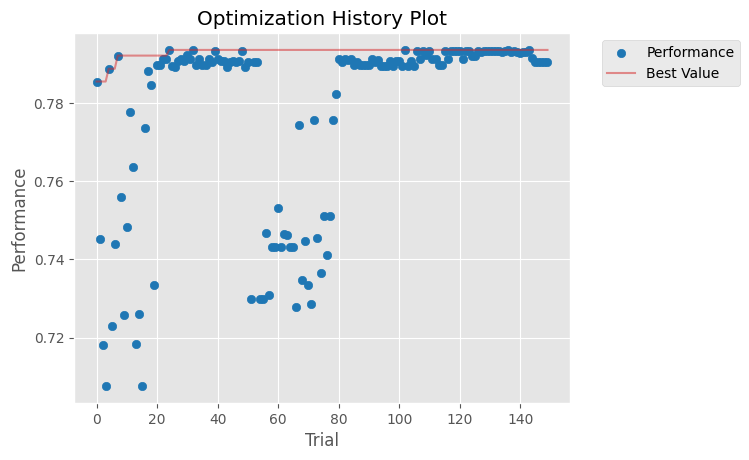

In [3]:
X_selected = X[
    [
        "carNumber",
        "positionGrid",
        "driverRef",
        "driverNumber",
        "constructorRef",
        "raceYear",
        "driverWins",
        "constructorWins",
        "weatherCold",
        "weatherWet",
        "driverAgeStarted",
        "driverPos8",
        "driverPos9",
        "driverPos11",
        "driverPos13",
        "driverPos14",
        "driverPos15",
        "driverPos16",
        "driverPos17",
        "driverPac",
        "driverOvr",
    ]
]
params = [
    ("int", ("n_neighbors", 1, 101)),
    ("categorical", ("metric", ["cosine", "euclidean", "manhattan"])),
    ("categorical", ("weights", ["distance", "uniform"])),
]
model = KNeighborsClassifier
scoring = make_scorer(balanced_accuracy_score)
model_tuning(params, model, X_selected, y, tscv, scoring)

## Decision Tree


DecisionTreeClassifier: 0.807 with {'max_depth': 4, 'criterion': 'entropy', 'splitter':
	'best'}


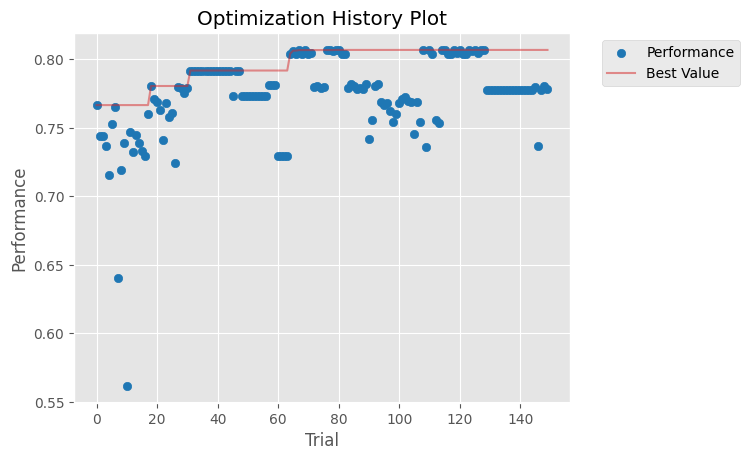

In [4]:
X_selected = X[
    [
        "positionGrid",
        "driverRef",
        "constructorRef",
        "constructorNationality",
        "raceYear",
        "circuitLocation",
        "circuitAlt",
        "driverWins",
        "q3",
        "weatherWarm",
        "weatherCold",
        "weatherWet",
        "weatherCloudy",
        "circuitType",
        "circuitDirection",
        "circuitLaps",
        "driverAgeStarted",
        "driverPos4",
        "driverPos5",
        "driverPos8",
        "driverPos10",
        "driverPos12",
        "driverPos13",
        "driverPos14",
        "driverPos15",
        "driverPos16",
        "driverPos17",
    ]
]
params = [
    ("int", ("max_depth", 1, 15)),
    ("categorical", ("criterion", ["gini", "log_loss", "entropy"])),
    ("categorical", ("splitter", ["best", "random"])),
]
model = DecisionTreeClassifier
scoring = make_scorer(balanced_accuracy_score)
model_tuning(params, model, X_selected, y, tscv, scoring)

## Random Forest


RandomForestClassifier: 0.797 with {'max_depth': 10, 'n_estimators': 355, 'criterion':
	'gini'}


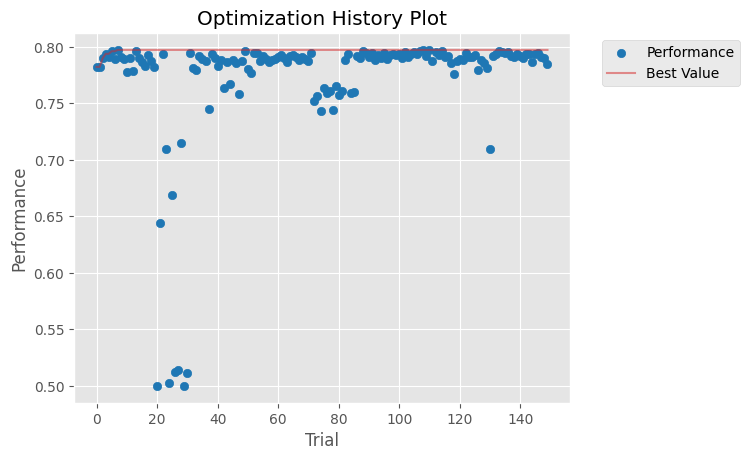

In [5]:
X_selected = X[
    [
        "positionGrid",
        "driverRef",
        "constructorRef",
        "raceYear",
        "driverWins",
        "q2",
        "weatherWarm",
        "weatherWet",
        "driverPodiums",
        "driverPos2",
        "driverPos5",
        "driverPos7",
        "driverPos9",
        "driverPos10",
        "driverPos11",
        "driverPos12",
        "driverPos16",
    ]
]
params = [
    ("int", ("max_depth", 1, 50)),
    ("int", ("n_estimators", 1, 500)),
    ("categorical", ("criterion", ["gini", "log_loss", "entropy"])),
]
model = RandomForestClassifier
scoring = make_scorer(balanced_accuracy_score)
model_tuning(params, model, X_selected, y, tscv, scoring)

## Multilayer Perceptron


MLPClassifier: 0.822 with {'activation': 'logistic', 'n_layers': 6, 'n_units_0': 83,
	'n_units_1': 40, 'n_units_2': 53, 'n_units_3': 88, 'n_units_4': 85, 'n_units_5': 68}


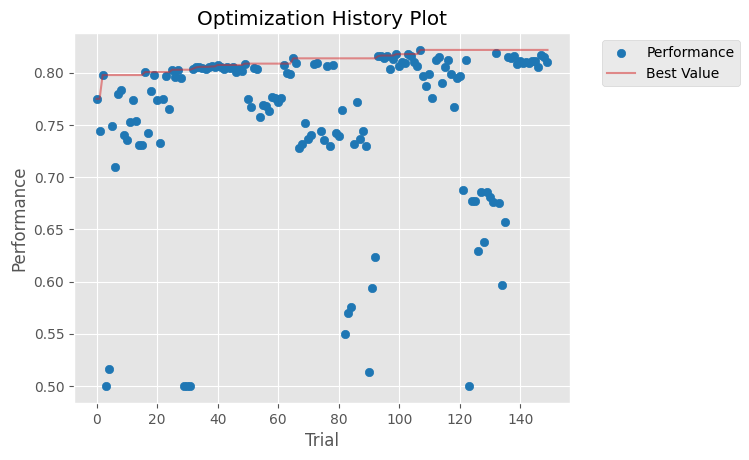

In [6]:
X_selected = X[
    [
        "positionGrid",
        "driverNationality",
        "circuitRef",
        "circuitLocation",
        "circuitLat",
        "circuitLng",
        "driverWins",
        "constructorWins",
        "q1",
        "q2",
        "driverAgeToday",
        "driverAgeAtRace",
        "weather",
        "weatherCold",
        "weatherWet",
        "weatherCloudy",
        "circuitDirection",
        "circuitLength",
        "circuitDist",
        "qMin",
        "qMax",
        "qAvg",
        "driverExpYear",
        "driverPos8",
        "driverPos9",
        "driverPos10",
        "driverPos13",
        "driverPos14",
        "driverPos17",
        "driverPos18",
        "driverExp",
    ]
]
params = [
    ("categorical", ("activation", ["tanh", "logistic", "relu", "identity"])),
    ("mlp", ("hidden_layer_sizes", 10, 100)),
]
model = MLPClassifier
scoring = make_scorer(balanced_accuracy_score)
model_tuning(params, model, X_selected, y, tscv, scoring)

## Results


Therefore, the tuning for each algorithm are as follows

- KNeighborsClassifier: 0.794 with {'n_neighbors': 62, 'metric': 'cosine', 'weights': 'distance'}
- DecisionTreeClassifier: 0.807 with {'max_depth': 4, 'criterion': 'entropy', 'splitter': 'best'}
- RandomForestClassifier: 0.797 with {'max_depth': 10, 'n_estimators': 355, 'criterion': 'gini'}
- MLPClassifier: 0.822 with {'activation': 'logistic', 'n_layers': 6, 'n_units_0': 83, 'n_units_1': 40, 'n_units_2': 53, 'n_units_3': 88, 'n_units_4': 85, 'n_units_5': 68}
